<a href="https://colab.research.google.com/github/nayoung718/essa_python_1/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_ch9_5_%ED%95%84%EC%82%AC_579p~_590p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파이썬 머신러닝 완벽가이드 ch9.5 필사 579p ~ 590p

## 05. 콘텐츠 기반 필터링 실습 -TMDB 5000 영화 데이터 세트

- 장르 속성을 이용한 영화 콘텐츠 기반 필터링 : 특정 영화 감상 후 좋아했다면 이와 비슷한 장르의 영화 추천 (장르 칼럼값 유사도 비교)

In [1]:
#데이터 로딩 및 가공
import pandas as pd
import numpy as np
import warnings
import warnings; warnings.filterwarnings('ignore')

movies = pd.read_csv('/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [3]:
movies_df = movies[['id','title','genres','vote_average','vote_count','popularity','keywords','overview']]

In [4]:
#list내부 dict있는 형태의 문자열로 표시한 경우 조심
pd.set_option('max_colwidth',100)
movies_df[['genres','keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


In [5]:
#series 객체의 apply()에 literal_eval 함수적용해 문자열을 객체로 변환
from ast import literal_eval
movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

In [6]:
#genre 리스트 내부 여러 장르 딕셔너리로 구성된 객체 가짐 -> 장르명만 리스트 객체로 추출
movies_df['genres'] = movies_df['genres'].apply(lambda x : [y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [y['name'] for y in x])
movies_df[['genres','keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


- 장르 콘텐츠 유사도 측정

genres를 문자열로 변경한 후 countvectorizer로 피처 벡터화한 행렬 데이터 값을 코사인 유사도로 비교

In [7]:
#피처 벡터화
from sklearn.feature_extraction.text import CountVectorizer

#CountVctorizer를 적용하기 위해 공백문자로 word단위가 구분되는 문자열로 변환.
movies_df['genres_literal']= movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df=0, ngram_range=(1,2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


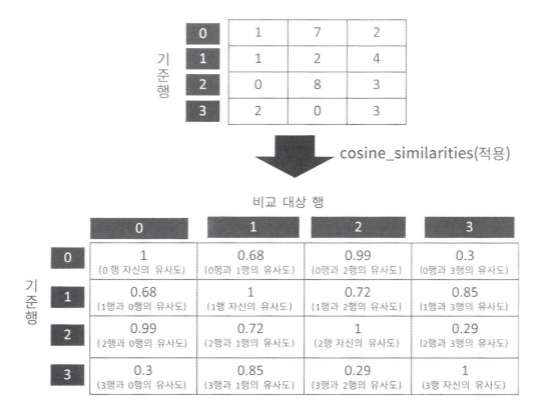

In [8]:
#코사인 유사도 행렬 형태로 반환
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:1])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]]


In [10]:
#유사도 값 높은 순 정렬된 행렬의 위치 인덱스값 추출
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])
#코사인 유사도 가장 노픙ㄴ순 -> 0번 레코드 제외하고 3494 레코드 가장 유사, 2401이 가장 유사도 낮음

[[   0 3494  813 ... 3038 3037 2401]]


- 장르 콘텐츠 필터링을 이용한 영화 추천

고객이 선정한 추천 기준이 되는 영화제목, 추천 영화 건수 입력시 추천 영화 정보 가지는 df 반환하는 함수

In [11]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  # 인자로 입력된 movies_df dataframe에서 'title' 칼럼이 입력된 title_name값인 dataframe 추출
  title_movie = df[df['title'] == title_name]
  # title_named을 가진 dataframe의 index 객체를 ndarray로 바노한하고
  # sorted_ind 인자로 입력된 genre_sim_sroted_ind 객체에서 유사도 순으로 top_n개의 index 추출
  title_index = title_movie.index.values
  similar_indexes = sorted_ind[title_index, :(top_n)]
  # 추출된 top_n index들 출력. top_n index는 2차원 데이터 임.
  #dataframe에서 index로 사용하기 위해서 1차원 array로 변경
  print(similar_indexes)
  similar_indexes = similar_indexes.reshape(-1)
  return df.iloc[similar_indexes]

In [12]:
similar_movies= find_sim_movie(movies, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


대부2편이 가장 먼저 추천, 하지만 대부 좋아하는 고객에게 추천하기 어려운 영화도 존재 평점이 낮거나 0인거 존재 -> 개선 필요

-좀더 많은 후보군 선정 후 평점 따라 필터링해 최종 추천

In [13]:
movies_df[['title','vote_average','vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


왜곡된 평점 데이터 회피하도록 평가횟수 반영한 평점 평가방식 필요

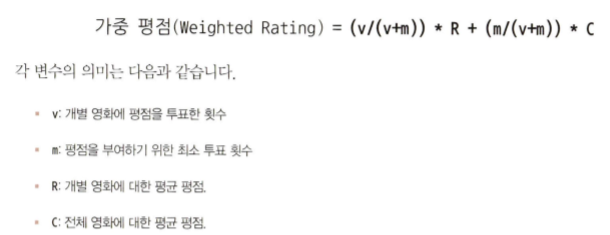


In [17]:
C= movies_df['vote_average'].mean()
m= movies_df['vote_count'].quantile(0.6)
print('C:',round(C,3),'m: ',round(m,3))

C: 6.092 m:  370.2


In [22]:
percentile=0.6
m= movies_df['vote_count'].quantile(percentile)
C= movies_df['vote_average'].mean()

def weighted_vote_average(record):
    v= record['vote_count']
    R= record['vote_average']
    return (v/(v+m)*R)+(m/(m+v)*C)

movies_df['weighted_vote'] = movies_df.apply(weighted_vote_average, axis=1)

In [23]:
#상위10개 영화 추출
movies_df[['title', 'vote_count', 'vote_average', 'weighted_vote']].sort_values('weighted_vote', ascending=False)[:10]

,title,vote_count,vote_average,weighted_vote
1881,The Shawshank Redemption,8205,8.5,8.396052
3337,The Godfather,5893,8.4,8.263591
662,Fight Club,9413,8.3,8.216455
3232,Pulp Fiction,8428,8.3,8.207102
65,The Dark Knight,12002,8.2,8.136930
1818,Schindler's List,4329,8.3,8.126069
3865,Whiplash,4254,8.3,8.123248
809,Forrest Gump,7927,8.2,8.105954
2294,Spirited Away,3840,8.3,8.105867
2731,The Godfather: Part II,3338,8.3,8.079586


In [24]:
#장르 유사성 높은 영화를 2배수만큼 후보군 선정후 weighted_vote 칼럼값 높은순으로 추출

def find_sim_movies(df, sorted_ind, title_name, top_n=10):
  title_movie=df[df['title']==title_name]
  title_index=title_movie.index.values

  #top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
  similar_indexes=sorted_ind[title_index, :(top_n*2)]
  similar_indexes = similar_indexes.reshape(-1)
  #기준 영화 인덱스는 제외
  similar_indexes = similar_indexes[similar_indexes != title_index]

  #top_n의 2배에 해당하는 후보군에서 weighted_vote 높은 순으로 top_n만큼 추출
  return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies= find_sim_movies(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title','vote_average','weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427
